In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('dataset/vietnamese_email_spam.csv')
data['Text'] = data['Text'].astype(str)
data.head()

,Text,Target
0,tiết kiệm cho bảo hiểm nhân thọ tại sao chi nh...,1
1,chống nguy cơ ung thư http www adclick ws p cf...,1
2,chống nguy cơ ung thư http www adclick ws p cf...,1
3,câu lạc bộ người lớn cung cấp quyền truy cập m...,1
4,Tôi nghĩ bạn có thể thích những slim down đảm ...,1


Text(0, 0.5, 'Number of Data points')

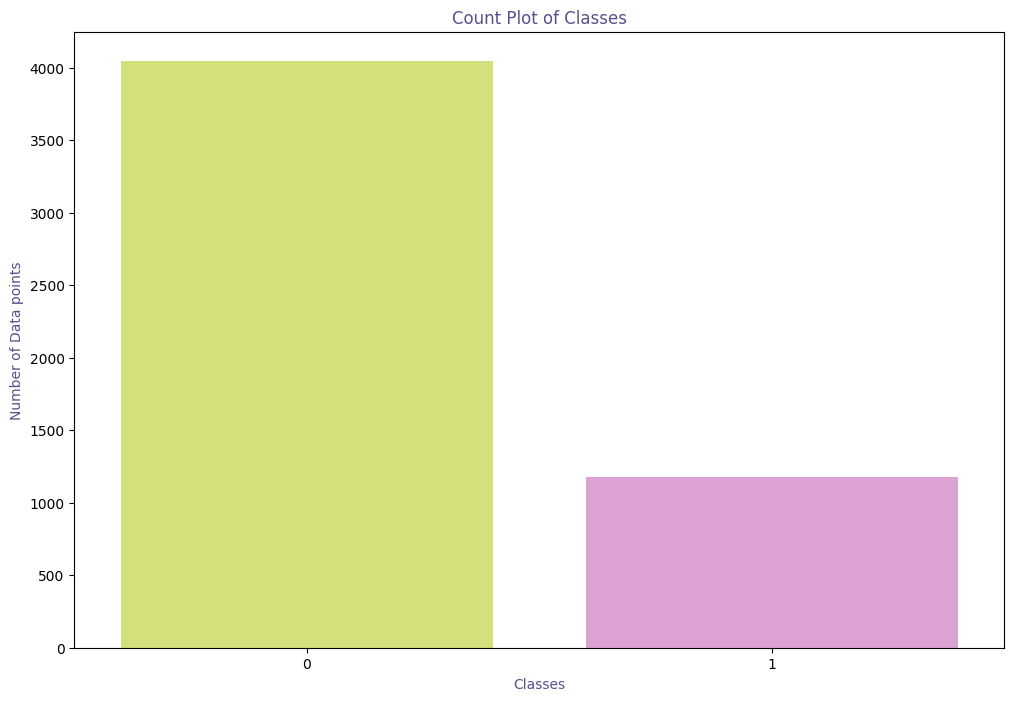

In [6]:
#Palette
cols= ["#E1F16B", "#E598D8"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [7]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,5222.0,0.225201,0.417755,0.0,0.0,0.0,0.00,1.0
No_of_Characters,5222.0,1633.622750,4868.937051,3.0,402.0,805.5,1474.75,164802.0
No_of_Words,5222.0,365.997128,1011.727591,1.0,88.0,179.0,332.00,29033.0
No_of_sentence,5222.0,3.968786,12.482770,1.0,1.0,2.0,3.00,369.0


<Figure size 1200x800 with 0 Axes>

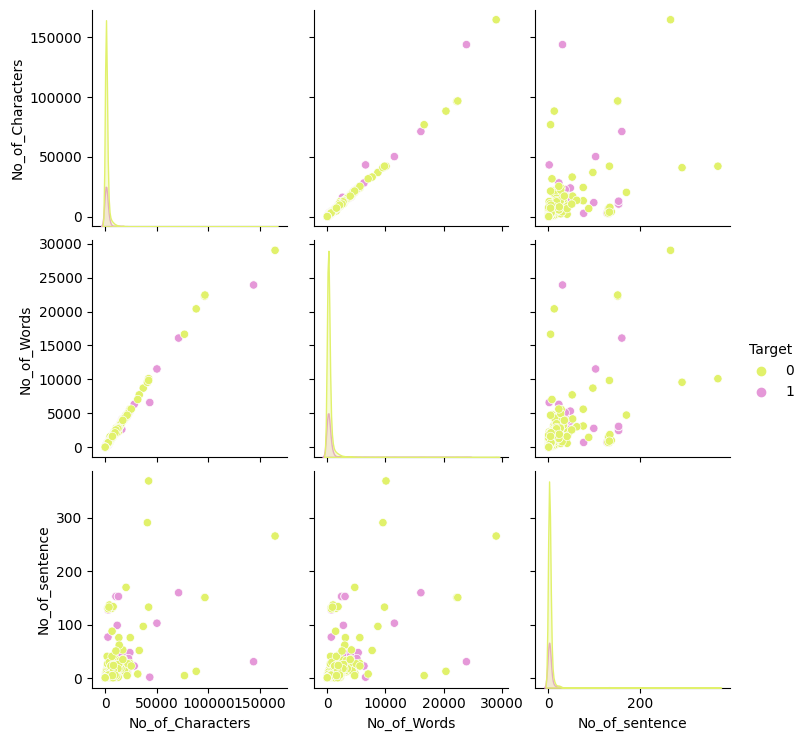

In [8]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

In [9]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<100000)]
data.shape

(5220, 5)

In [ ]:
from bs4 import BeautifulSoup

# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    if sms == '':
        sms = np.nan
    return sms

def remove_tags(html):
    # parse html content
    soup = BeautifulSoup(html, "html.parser")
    
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
    
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

data["Clean_Text"] = data["Text"].apply(remove_tags)
data["Clean_Text"] = data["Clean_Text"].apply(Clean)
data = data.dropna()
data.head()

,Text,Target,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,191,12,save up to on life insurance why spend more th...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,139,5,fight the risk of cancer http www adclick ws p...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,113,4,fight the risk of cancer http www adclick ws p...
3,##############################################...,1,2863,690,35,adult club offers free membership instant acce...
4,I thought you might like these:\n1) Slim Down ...,1,641,108,4,i thought you might like these slim down guara...


In [10]:
data.head()

,Text,Target,No_of_Characters,No_of_Words,No_of_sentence
0,tiết kiệm cho bảo hiểm nhân thọ tại sao chi nh...,1,1047,238,2
1,chống nguy cơ ung thư http www adclick ws p cf...,1,710,161,3
2,chống nguy cơ ung thư http www adclick ws p cf...,1,537,128,3
3,câu lạc bộ người lớn cung cấp quyền truy cập m...,1,2513,558,6
4,Tôi nghĩ bạn có thể thích những slim down đảm ...,1,607,134,2


In [11]:
from sentence_transformers import SentenceTransformer
embedModel = SentenceTransformer('keepitreal/vietnamese-sbert')

In [13]:
X = embedModel.encode(data["Text"].values.tolist())
X.shape

(5220, 768)

In [15]:
from sklearn.preprocessing import LabelEncoder
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

In [16]:
from sklearn.model_selection import train_test_split

y = data["Target"]
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Testing on the following classifiers
classifiers = [
    LGBMClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(), 
    SVC()
]


# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LightGBM", 1: "RandomForest", 2: "KNN", 3: "SVM"}

for i in range(len(classifiers)):
    print(f'train {pipe_dict[i]}')
    classifiers[i].fit(X_train, y_train)

train LightGBM
[LightGBM] [Info] Number of positive: 923, number of negative: 3253
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4176, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221025 -> initscore=-1.259704
[LightGBM] [Info] Start training from score -1.259704
train RandomForest
train KNN
train SVM


In [ ]:
from sklearn.model_selection import cross_val_score

for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

[LightGBM] [Info] Number of positive: 1337, number of negative: 3013
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97901
[LightGBM] [Info] Number of data points in the train set: 4350, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.307356 -> initscore=-0.812508
[LightGBM] [Info] Start training from score -0.812508
[LightGBM] [Info] Number of positive: 1337, number of negative: 3013
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97901
[LightGBM] [Info] Number of data points in the train set: 4350, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.307356 -> initscore=-0.812508
[LightGBM] [Info] Start training from score -0.812508
[LightGB

In [18]:
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = i.score(X_train,y_train)
    test_accuracy = i.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [19]:
# initialise data of lists.
data_eva = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data_eva, index =["LightGBM", "RandomForest", "KNN","SVC"])

In [20]:
from matplotlib.colors import ListedColormap

cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
LightGBM,0.804428,0.865079,0.833652,0.916667,0.964320
RandomForest,0.801724,0.738095,0.768595,0.892720,0.964320
KNN,0.794776,0.845238,0.819231,0.909962,0.933669
SVC,0.819788,0.920635,0.867290,0.931992,0.950670


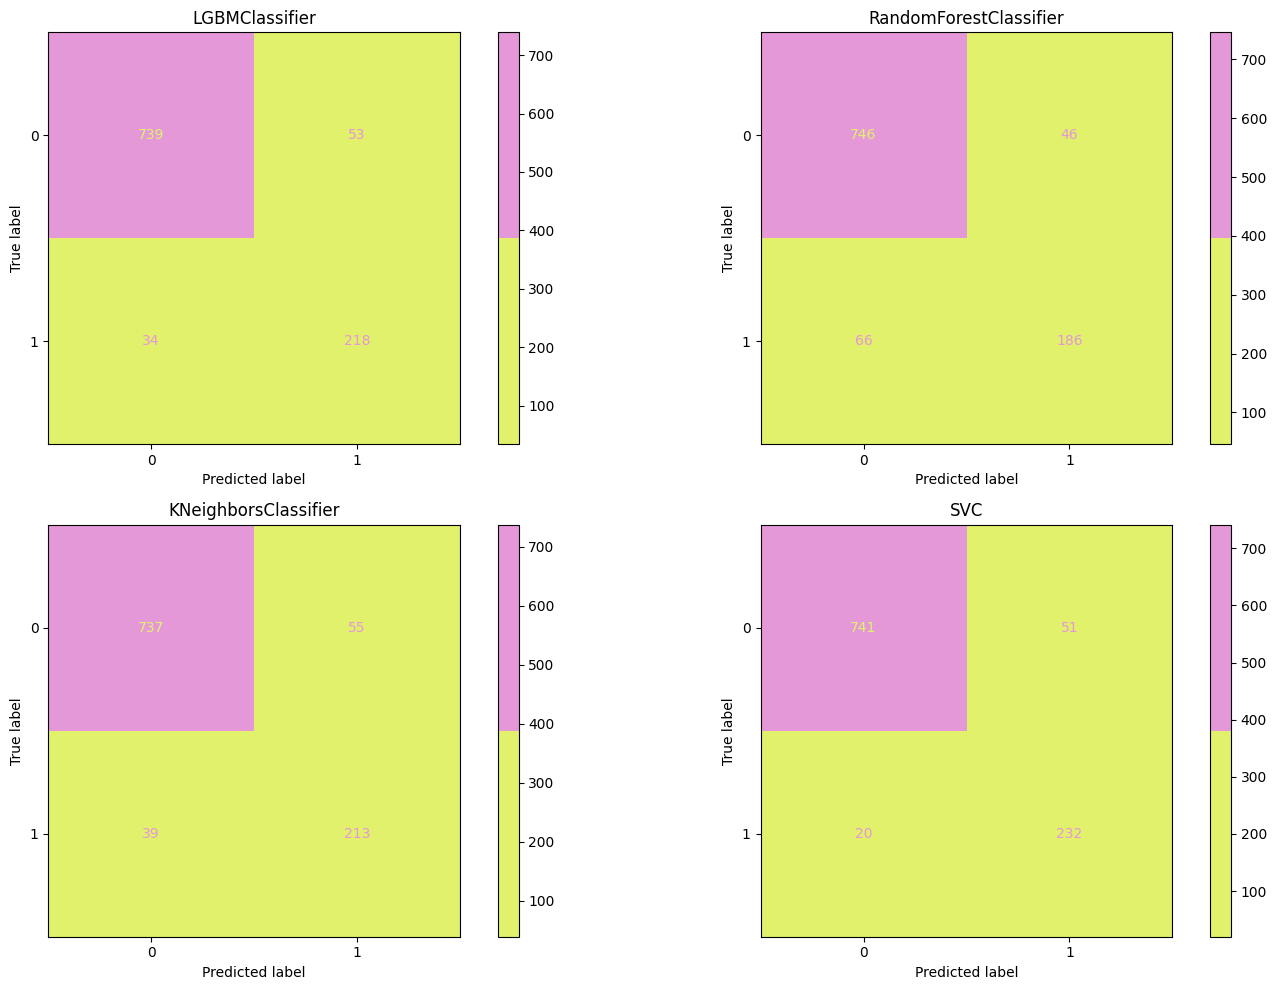

In [21]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for cls, ax in zip(classifiers, axes.flatten()):
    y_pred = cls.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls.classes_)
    disp.plot(cmap=cmap, ax=ax)
    ax.set_title(type(cls).__name__)

plt.tight_layout()
plt.show()

In [31]:
from bs4 import BeautifulSoup

def clean(text):
    sms = re.sub('[^a-zA-Z]', ' ', text)  # Replacing all non-alphabetic characters with a space
    sms = sms.lower()  # converting to lowercase
    if sms == '':
        sms = np.nan
    return sms


def remove_tags(html):
    # parse html content
    soup = BeautifulSoup(html, "html.parser")

    for tmp_data in soup(['style', 'script']):
        # Remove tags
        tmp_data.decompose()

    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

def predict_ham_spam(model, text):
    input = pd.DataFrame([text], columns=['Text'])
    input["Clean_Text"] = input["Text"].apply(remove_tags)
    input["Clean_Text"] = input["Clean_Text"].apply(clean)
    X = embedModel.encode(input["Clean_Text"].values.tolist())
    # print(X)
    return model.predict(X)[0]

In [33]:
result = predict_ham_spam(classifiers[3], text="""Vé sự kiện từ Hanoi Rock City!
""")
if result == 1:
    print("Spam")
else:
    print("Ham")

Ham


In [34]:
import pickle

pickle.dump(classifiers[3], open('model/svm_vn_model.sav','wb'))